<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Требуется спрогнозировать уход клиента из банка на основе исторических данных о поведении клиентов и расторжении договоров с банком. Для оценки модели нужно использовать F1-меру и AUC-ROC.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Первоначальные выводы по данным:
1. RowNumber и Surname — нужно удалить, так как индекс и фамилия не влияют на целевой признак
2. CustomerId — тоже удалить, но сначала стоит проверить на дубликаты
3. Tenure - есть пропуски
4. Geography и Gender - столбцы с типом object, нужно перевести их в численные, используя ОНЕ (так как ОНЕ подходит и для линейной регрессии)
5. Провести масштабирование признаков
6. Для удобства стоит привести все названия столбцов к нижнему регистру
7. Нужно отделить целевой признак и разделить данные на три выборки в соотношении 60-20-20

In [2]:
#Привожу названия стобцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [3]:
#Проверяю столбец CustomerId на дубликаты
data.customerid.duplicated().sum()

0

Дубликатов нет, можно удалять

In [4]:
#Удаляю нкоторые столбцы
data = data.drop(['rownumber', 'surname', 'customerid'], axis=1)
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
#Заменяю пропуски в Tenure
data[data['tenure'].isnull()]
data['tenure'] = data['tenure'].fillna(value=0)
display(data[data['tenure'] == 0])
data[data['tenure'].isnull()]

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
29,411,France,Male,29,0.0,59697.17,2,1,1,53483.21,0
30,591,Spain,Female,39,0.0,0.00,3,1,0,140469.38,1
35,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
48,550,Germany,Male,38,0.0,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,0.0,146050.97,2,0,0,86424.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,0.0,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,0.0,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,0.0,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,0.0,123841.49,2,1,0,96833.00,0


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited


Пропусков в столбце с количеством лет клиента в банке много (10% от всей таблицы) - удалять их нельзя.
Вычислить их из других данных невозможно, заменить средним тоже. Оставшееся решение - заменить их на нули

In [6]:
#Перевожу Geography и Gender из категориальных в численные
data = pd.get_dummies(data, drop_first=True)
data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Я не стала сбрасывать первый столбец Geography, так как он несет в себе неповторимую информацию (в данных представлены всего 3 страны - Германия, Испания и Франция. При удалении первого столбца Франция исчезает).
А из Gender удалила первый столбец вручную

In [7]:
#Отделяю целевой признак
features = data.drop(['exited'], axis=1)
target = data['exited']

#Разделяю данные на три выборки


features_train, features_, target_train, target_ = train_test_split(features,
                                                                    target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_,
                                                                    target_, test_size=0.5, random_state=42)
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)
features_train.head()

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9761,807,60,0.0,72948.58,2,1,1,17355.36,1,0,0
3159,834,23,4.0,131254.81,1,1,0,20199.30,0,0,1
1489,609,39,8.0,141675.23,1,0,1,175664.25,0,0,0
2987,676,26,1.0,108348.66,1,0,0,60231.74,1,0,0
812,516,33,3.0,0.00,2,1,1,58685.59,0,1,0


In [8]:
#Провожу масштабирование признаков

num = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9761,1.603068,2.027653,-1.457665,-0.048229,0.824078,0.645833,0.964303,-1.452982,1,0,0
3159,1.883194,-1.520072,-0.168647,0.884122,-0.905967,0.645833,-1.037018,-1.403696,0,0,1
1489,-0.451185,0.014079,1.120372,1.050751,-0.905967,-1.548389,0.964303,1.290549,0,0,0
2987,0.243941,-1.232419,-1.135410,0.517839,-0.905967,-1.548389,-1.037018,-0.709924,1,0,0
812,-1.416062,-0.561228,-0.490901,-1.214721,0.824078,0.645833,0.964303,-0.736719,0,1,0


В ходе подготовки данных были: удалены неинформативные столбцы, заполнены пропуски, категориальные переменные переведены в численные, проведено масштабирование остальных численных признаков. Так же данные были разделены на обучающую, валидационную и тестовую выборки

## Исследование задачи

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [9]:
#Исследую баланс классов
print('Положительных отметок', target_train.sum())
print('Отрицательных отметок', len(target_train) - target_train.sum())
(len(target_train) - target_train.sum()) / target_train.sum()

Положительных отметок 1227
Отрицательных отметок 4773


3.8899755501222493

Количество людей, ушедших из банка, почти в 4 раза меньше, чем количество оставшихся. Дисбаланс заметный

In [10]:
#Работа модели без учета дисбаланса (логистическая регрессия)
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
proba = model.predict_proba(features_valid)
predictions_const = np.zeros(len(target_valid)).astype('int')

print('F1', f1_score(target_valid, predictions_valid))
print('F1 constant', f1_score(target_valid, predictions_const))
print('AUC-ROC', roc_auc_score(target_valid, proba[:, 1]))
predictions_const
predictions_valid

F1 0.2967244701348748
F1 constant 0.0
AUC-ROC 0.7532797270955165


array([0, 0, 0, ..., 0, 1, 0])

In [11]:
#ДЕРЕВО

f1_max = 0
auc_max = 0

for n in range(1, 20):
    model = DecisionTreeClassifier(random_state=42, max_depth=n)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])

    
    if f1 > f1_max:
        f1_max = f1
        n_f1 = n
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        n_auc = n       

print(n_f1, 'F1', f1_max)  
print(n_auc, 'AUC-ROC', auc_max)

6 F1 0.527687296416938
6 AUC-ROC 0.8073984730344379


In [12]:
#СЛУЧАЙНЫЙ ЛЕС

n = 20
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
d_l = list()

for d in range(1, 20):
    model = RandomForestClassifier(random_state=42, max_depth=d, n_estimators=n)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    if f1 > f1_max:
        f1_max = f1
        d_f1 = d
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        d_auc = d    

print(d_f1, 'F1', f1_max)
print(d_auc, 'AUC-ROC', auc_max)
print()

d = d_f1
f1_max = 0
auc_max = 0

for n in range(10, 100, 10):
    model = RandomForestClassifier(random_state=42, max_depth=d, n_estimators=n)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])

    if f1 > f1_max:
        f1_max = f1
        n_f1 = n
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        n_auc = n    

print(n_f1, 'F1', f1_max)
print(n_auc, 'AUC-ROC', auc_max)

17 F1 0.5636070853462158
7 AUC-ROC 0.8444720597790774

70 F1 0.5742251223491027
90 AUC-ROC 0.8336663417803769


При работе модели без учета дисбаланса классов были получены значения:
- F1 0.296
- AUC-ROC 0.753
Значение AUC-ROC модели больше 0.5 (что соотвествует случайной модели), значит модель уже точнее предсказывает, чем случайная. Хотя положительного класса почти в 4 раза меньше, чем отрицательного.


*Я пыталась для сравнения посчитать F1 константной модели (предсказывает только нули), но не смогла. Подскажите, пожалуйста, в чем проблема*

## Борьба с дисбалансом

Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

In [13]:
#Модель логистической регрессии со сбалансированными классами
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
proba = model.predict_proba(features_valid)

print('F1', f1_score(target_valid, predictions_valid))
print('AUC-ROC', roc_auc_score(target_valid, proba[:, 1]))

F1 0.4660869565217392
AUC-ROC 0.7540432098765433


В сравнении с несбалансированными классами модель показала улучшение F1 (с 0.296 до 0.466), тогда как AUC-ROC почти не изменилась

3 F1 0.46997929606625255
4 AUC-ROC 0.7540302144249511


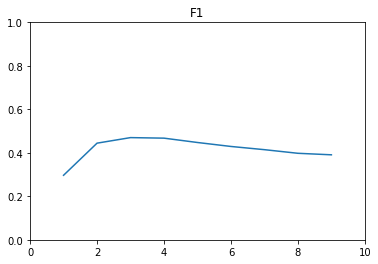

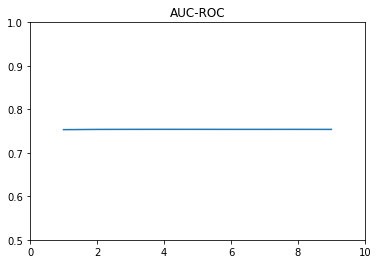

In [14]:
#Upsampling


def upsampling(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_up = pd.concat([features_zeros] + [features_ones] * repeat)
    target_up = pd.concat([target_zeros] + [target_ones] * repeat)

    features_up, target_up = shuffle(features_up, target_up, random_state=42)
    return features_up, target_up

#Подбираем во сколько раз увеличить количество положительного класса
f1_max = 0
auc_max = 0

f1_l = list()
auc_l = list()
rep_l = list()

for rep in range(1, 10):
    features_up, target_up = upsampling(features_train, target_train, rep)

    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    rep_l.append(rep)
    
    if f1 > f1_max:
        f1_max = f1
        rep_max = rep

    if auc_roc > auc_max:
        auc_max = auc_roc
        rep_auc = rep 
       
print(rep_max, 'F1', f1_max)  
print(rep_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 10, 0, 1])
plt.plot(rep_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 10, 0.5, 1])
plt.plot(rep_l, auc_l)
plt.title('AUC-ROC')
plt.show()

Значение F1 было максимальным (0.469) при увеличении положительного класса в 3 раза. Такое F1 больше предыдущих (0.296 и 0.466).
AUC-ROC изменилась незначительно

3 F1 0.5474613686534215
6 AUC-ROC 0.8113897011046134


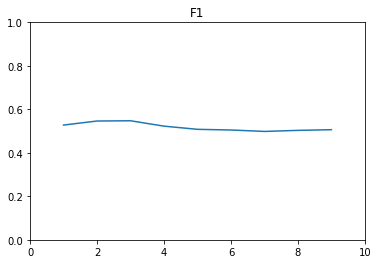

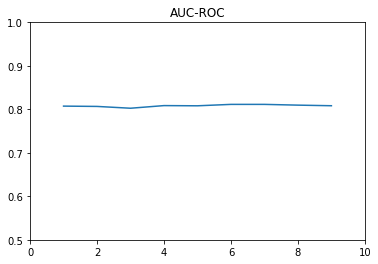

In [15]:
#Подбираем во сколько раз увеличить количество положительного класса ДЛЯ ДЕРЕВА
f1_max = 0
auc_max = 0

f1_l = list()
auc_l = list()
rep_l = list()

for rep in range(1, 10):
    features_up, target_up = upsampling(features_train, target_train, rep)

    model = DecisionTreeClassifier(random_state=42, max_depth=6)
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    rep_l.append(rep)
    
    if f1 > f1_max:
        f1_max = f1
        rep_max = rep

    if auc_roc > auc_max:
        auc_max = auc_roc
        rep_auc = rep 
       
print(rep_max, 'F1', f1_max)  
print(rep_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 10, 0, 1])
plt.plot(rep_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 10, 0.5, 1])
plt.plot(rep_l, auc_l)
plt.title('AUC-ROC')
plt.show()

3 F1 0.5794655414908579
2 AUC-ROC 0.8355133203378817


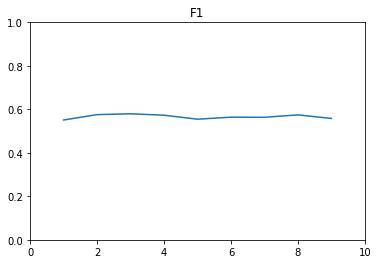

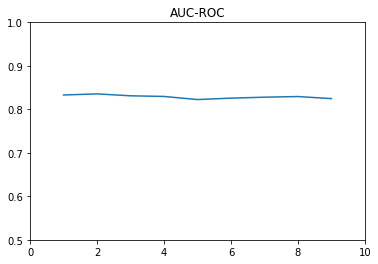

In [16]:
#Подбираем во сколько раз увеличить количество положительного класса ДЛЯ СЛУЧАЙНОГО ЛЕСА
f1_max = 0
auc_max = 0

f1_l = list()
auc_l = list()
rep_l = list()

for rep in range(1, 10):
    features_up, target_up = upsampling(features_train, target_train, rep)

    model = RandomForestClassifier(random_state=42, max_depth=17, n_estimators=70)
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    rep_l.append(rep)
    
    if f1 > f1_max:
        f1_max = f1
        rep_max = rep

    if auc_roc > auc_max:
        auc_max = auc_roc
        rep_auc = rep 
       
print(rep_max, 'F1', f1_max)  
print(rep_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 10, 0, 1])
plt.plot(rep_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 10, 0.5, 1])
plt.plot(rep_l, auc_l)
plt.title('AUC-ROC')
plt.show()

0.4 F1 0.46712018140589573
0.4 AUC-ROC 0.754343729694607


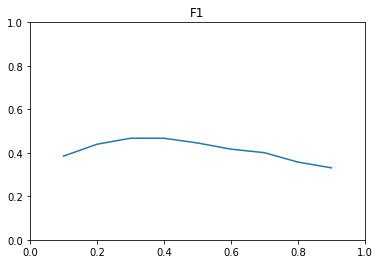

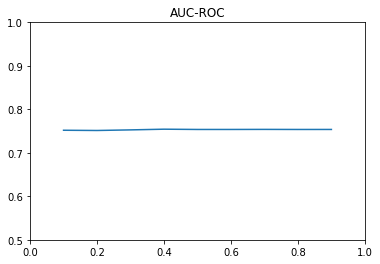

In [17]:
#Downsampling


def downsampling(features, target, fraction):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_zeros = features_zeros.sample(frac=fraction, random_state=42)
    target_zeros = target_zeros.sample(frac=fraction, random_state=42)
    
    features_down = pd.concat([features_zeros] + [features_ones])
    target_down = pd.concat([target_zeros] + [target_ones])

    features_down, target_down = shuffle(features_down, target_down, random_state=42)
    return features_down, target_down

#Подбираем во сколько раз уменьшить количество отрицательного класса
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
fr_l = list()

for fraction in np.arange(0.1, 1, 0.1):
    features_down, target_down = downsampling(features_train, target_train, fraction)

    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(features_down, target_down)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    fr_l.append(fraction)
    
    if f1 > f1_max:
        f1_max = f1
        fr_max = fraction

    if auc_roc > auc_max:
        auc_max = auc_roc
        fr_auc = fraction 
        
print(fr_max, 'F1', f1_max)  
print(fr_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 1, 0, 1])
plt.plot(fr_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 1, 0.5, 1])
plt.plot(fr_l, auc_l)
plt.title('AUC-ROC')
plt.show()

0.6 F1 0.5616045845272206
0.6 AUC-ROC 0.8108512020792723


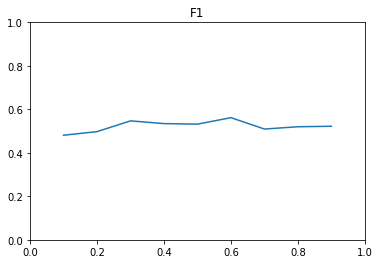

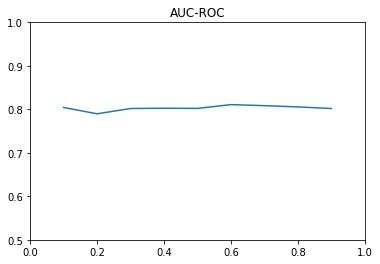

In [18]:
#Подбираем ДЛЯ ДЕРЕВА
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
fr_l = list()

for fraction in np.arange(0.1, 1, 0.1):
    features_down, target_down = downsampling(features_train, target_train, fraction)

    model = DecisionTreeClassifier(random_state=42, max_depth=6)
    model.fit(features_down, target_down)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    fr_l.append(fraction)
    
    if f1 > f1_max:
        f1_max = f1
        fr_max = fraction

    if auc_roc > auc_max:
        auc_max = auc_roc
        fr_auc = fraction 
        
print(fr_max, 'F1', f1_max)  
print(fr_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 1, 0, 1])
plt.plot(fr_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 1, 0.5, 1])
plt.plot(fr_l, auc_l)
plt.title('AUC-ROC')
plt.show()

0.4 F1 0.5791962174940898
0.7000000000000001 AUC-ROC 0.8333609486679661


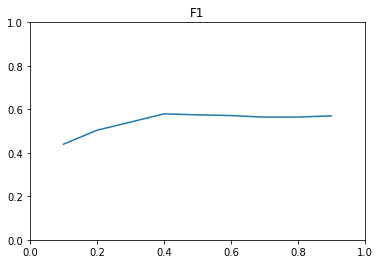

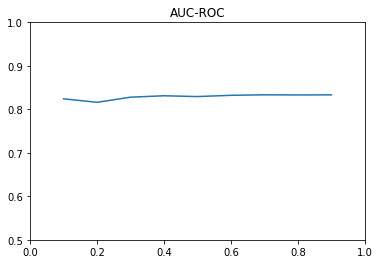

In [19]:
#Подбираем ДЛЯ СЛУЧАЙНОГО ЛЕСА
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
fr_l = list()

for fraction in np.arange(0.1, 1, 0.1):
    features_down, target_down = downsampling(features_train, target_train, fraction)

    model = RandomForestClassifier(random_state=42, max_depth=17, n_estimators=70)
    model.fit(features_down, target_down)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    fr_l.append(fraction)
    
    if f1 > f1_max:
        f1_max = f1
        fr_max = fraction

    if auc_roc > auc_max:
        auc_max = auc_roc
        fr_auc = fraction 
        
print(fr_max, 'F1', f1_max)  
print(fr_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 1, 0, 1])
plt.plot(fr_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 1, 0.5, 1])
plt.plot(fr_l, auc_l)
plt.title('AUC-ROC')
plt.show()

Значение F1 было максимальным (0.467), когда в данных осталось 0.4 части отрицательного класса. Такое F1 меньше, чем при использовании upsampling. Я думаю, это связано с тем, что общее количество данных, используемых для обучения, уменьшилось.
AUC-ROC изменилась незначительно.

Для дальнейшей работы с данными я буду использовать обучающую выборку, обработанную upsampling

6 F1 0.5064102564102564
6 AUC-ROC 0.8082813515269656


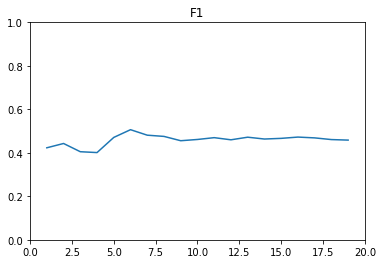

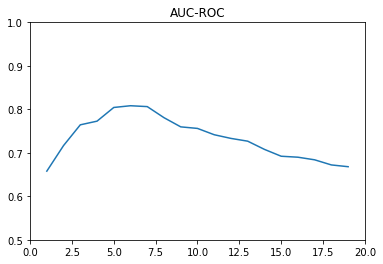

In [20]:
#Поиск лучшей модели
#дерево


f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
n_l = list()

for n in range(1, 20):
    model = DecisionTreeClassifier(random_state=42, max_depth=n)
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    n_l.append(n)
    
    if f1 > f1_max:
        f1_max = f1
        n_f1 = n
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        n_auc = n       

print(n_f1, 'F1', f1_max)  
print(n_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 20, 0, 1])
plt.plot(n_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 20, 0.5, 1])
plt.plot(n_l, auc_l)
plt.title('AUC-ROC')
plt.show()

18 F1 0.5683646112600536
7 AUC-ROC 0.8353378817413905

d=18, AUC-ROC 0.8152932098765433


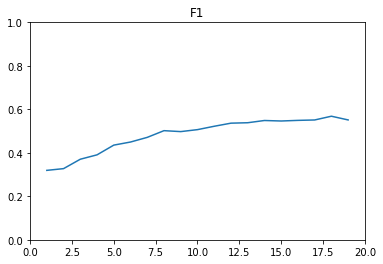

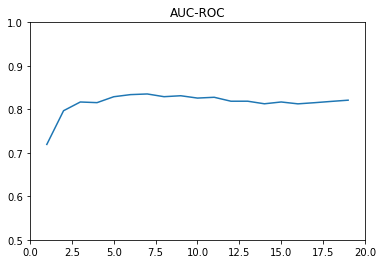

In [24]:
#случайный лес


#Ищем лучшую максимальную глубину дерева при фиксированном количестве деревьев (20)
n = 20
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
d_l = list()

for d in range(1, 20):
    model = RandomForestClassifier(random_state=42, max_depth=d, n_estimators=n)
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    d_l.append(d)
    
    if f1 > f1_max:
        f1_max = f1
        d_f1 = d
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        d_auc = d    
        
    if d == 17:
        a = auc_roc

print(d_f1, 'F1', f1_max)
print(d_auc, 'AUC-ROC', auc_max)
print()
print('d=18, AUC-ROC', a)

#строим графики
plt.axis([0, 20, 0, 1])
plt.plot(d_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 20, 0.5, 1])
plt.plot(d_l, auc_l)
plt.title('AUC-ROC')
plt.show()

Наилучшее значение F1 для случайного леса соотвествует максимальной глубине 17, но значение AUC-ROC при этой глубине ниже, чем при глубине 9

90 F1 0.5740987983978638
90 AUC-ROC 0.8252404158544508


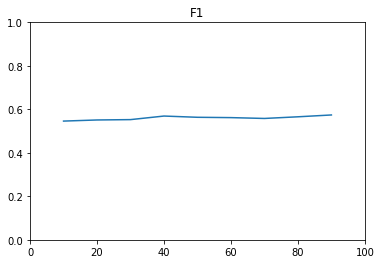

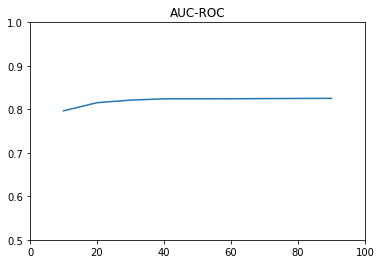

In [22]:
#Ищем количество деревьев при максимальной глубине 17
d = 17
f1_max = 0
auc_max = 0
f1_l = list()
auc_l = list()
n_l = list()

for n in range(10, 100, 10):
    model = RandomForestClassifier(random_state=42, max_depth=d, n_estimators=n)
    model.fit(features_up, target_up)
    predictions_valid = model.predict(features_valid)
    proba = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, proba[:, 1])
    
    f1_l.append(f1)
    auc_l.append(auc_roc)
    n_l.append(n)
    
    if f1 > f1_max:
        f1_max = f1
        n_f1 = n
        
    if auc_roc > auc_max:
        auc_max = auc_roc
        n_auc = n    

print(n_f1, 'F1', f1_max)
print(n_auc, 'AUC-ROC', auc_max)

#строим графики
plt.axis([0, 100, 0, 1])
plt.plot(n_l, f1_l)
plt.title('F1')
plt.show() 

plt.axis([0, 100, 0.5, 1])
plt.plot(n_l, auc_l)
plt.title('AUC-ROC')
plt.show()

Для различных моделей получены значения:
1. Случайный лес: F1 0.5676, AUC-ROC 0.8184
2. Дерево: F1 0.5039, AUC-ROC 0.8091
3. Логистическая регрессия: F1 0.4694, AUC-ROC 0.7540

Самая точная модель из указанных - случайный лес с параметрами: максимальная глубина 17, количество деревьев 80

## Тестирование модели

In [26]:
%%time
model = RandomForestClassifier(random_state=42, max_depth=17, n_estimators=80)
model.fit(features_up, target_up)
predictions_test = model.predict(features_test)
proba = model.predict_proba(features_test)
f1 = f1_score(target_test, predictions_test)
auc_roc = roc_auc_score(target_test, proba[:, 1])

print('F1', f1)
print('AUC-ROC', auc_roc)

F1 0.6242350061199511
AUC-ROC 0.8539046067249295
CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.51 s


На тестовых данных метрика F1 для указанной модели составляет 0.6228, а метрика AUC-ROC 0.8570

<b>Вывод:</b>
    В данном задании требовалось спрогнозировать уход клиента из банка на основе исторических данных о поведении клиентов. Данные были подготовлены и прошли масштабирование, а после разделены на обучающую, валидационную и тестовую выборки.
    Был найден существенный дисбаланс классов, и проверены три способа исправления дисбаланса (для различных моделей). Оптимальным оказалось сочетание учета дисбаланса с помощью upsampling и модели случайного леса. Далее были проверены указанные модели при различных гиперпараметрах на валидационной выборке. Лучшая модель (случайный лес с максимальной глубиной 17, количеством деревьев 80) была протестирована на тестовой выборке.
    
Полученные метрики модели: 
    F1 0.6242
    AUC-ROC 0.8539
    
</div>